# IMDB reviews classification with plain RNN

In [1]:
import torch
from fastai.text.all import *

%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
import gc
gc.collect()

torch.cuda.empty_cache()

In [4]:
dataset_path = untar_data(URLs.IMDB)
dataset_files = get_text_files(dataset_path, folders=['train', 'test'])

tok_rules = [
    lowercase,
    fix_html,
    spec_add_spaces,
    rm_useless_spaces,
]
x_tfms = [
    Tokenizer.from_folder(dataset_path, tok=TokenizeWithRules(WordTokenizer(), tok_rules), rules=[]),
    Numericalize(max_vocab=16_000)
]
y_tfms = [
    parent_label, 
    Categorize()
]

splitter = GrandparentSplitter(train_name='train', valid_name='test')(dataset_files)
dsets = Datasets(dataset_files, [x_tfms, y_tfms], splits = splitter)
dloaders = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

2023-11-28 22:52:40.719522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 22:52:41.349037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-28 22:52:41.840758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 22:52:41.844641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 22:52:41.844679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

In [5]:
vocab_len = len(x_tfms[1].vocab)
vocab_len

16008

### Batching
* dataset is sorted, so samples in 1 batch have ~same length
* samples are padded to the longest text in the batch 

In [6]:
dloaders = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input, bs=16)
dloaders.one_batch()

(TensorText([[12628,   506,   103,  ...,    30,   158,   699],
             [  964,    23,   146,  ...,     1,     1,     1],
             [   35,    23,   269,  ...,     1,     1,     1],
             ...,
             [  292,    98,   920,  ...,     1,     1,     1],
             [    0,     0,  1245,  ...,     1,     1,     1],
             [ 3176,   103,   292,  ...,     1,     1,     1]], device='cuda:0'),
 TensorCategory([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1],
                device='cuda:0'))

## Simple RNN model

In [7]:
class Rnn(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.w_i = nn.Parameter(torch.zeros([vocab_size, hidden_size]).normal_(0, 0.01))
        self.w_h = nn.Parameter(torch.zeros([hidden_size, hidden_size]).normal_(0, 0.01))
        self.b_h = nn.Parameter(torch.zeros([hidden_size]))
        
        self.w_o = nn.Parameter(torch.zeros([hidden_size, output_dim]).normal_(0, 0.01))
        self.b_o = nn.Parameter(torch.zeros([output_dim]))
        
    def forward(self, x): 
        one_hot = F.one_hot(x, num_classes=self.vocab_size).float()
        h = torch.zeros([self.hidden_size]).normal_(0, 0.01)
        if torch.cuda.is_available():
            h = h.to(device='cuda')

        # recurrence
        for i in range(x.shape[1]):
            h = one_hot[:,i,:] @ self.w_i + h @ self.w_h + self.b_h
            h = torch.sigmoid(h)
        
        # output
        h = h @ self.w_o + self.b_o
        h = torch.relu(h)
        
        return h
rnn = Rnn(vocab_len, 64, 2)
if torch.cuda.is_available():
    rnn.cuda()

# display(L(rnn.parameters(dsets)))
display(rnn.forward(dloaders.one_batch()[0]).shape)

learner = Learner(dloaders, rnn, loss_func=F.cross_entropy, metrics=accuracy)

torch.Size([16, 2])

SuggestedLRs(minimum=2.7542287170945203e-07, steep=6.309573450380412e-07, valley=0.10000000149011612, slide=0.2089296132326126)

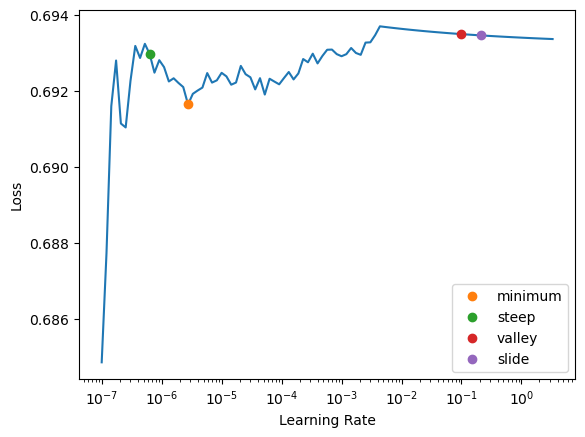

In [8]:
# there different methods for finding best lr; valley tends to give best results
# see https://forums.fast.ai/t/new-lr-finder-output/89236/2 
learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [10]:
learner.fit_one_cycle(4, 0.1)

KeyboardInterrupt: 

In [ ]:
plt.plot(L(learner.recorder.values).itemgot(0))

In [ ]:
learner.recorder.plot_sched()

In [9]:
# clean gpu memory
learn = None
rnn = None
gc.collect()
torch.cuda.empty_cache()